# Part 2: Fraud Detection Models with and without FraudKiller

## Prerequisites
This notebook builds upon the analysis in `01_Anomaly_Detection_Analysis.ipynb`.
Make sure you have completed Part 1 or have the processed datasets available.

## Objective
Evaluate whether incorporating **FraudKiller** features into our fraud detection models improves performance and business outcomes. We will:
- Build and compare models with and without FraudKiller features
- Optimize decision thresholds to maximize profit
- Assess the business impact of using FraudKiller features


## Feature Engineering

### 1. Feature Creation
- **IPAddressLocCity_is_null**: Binary indicator for missing IP address location city (handles missing data)
- **Temporal Features**: Extracted `hour`, `day_of_week`, and `week_of_year` from `opendate` to capture temporal patterns

### 2. Data Transformation
- Removed original `opendate` column after extracting temporal features
- Removed `ID` column (not useful for modeling)

### 3. Missing Value Handling
- **Numerical columns**: Mean imputation
- **Categorical columns**: Mode (most frequent) imputation

### 4. Encoding
- **One-hot encoding** for categorical features: `AreaCode`, `DeviceBrowserType`, `IpAddressLocCity`, `IpAddressLocCountry`
- Drop first category to avoid multicollinearity

### 5. Feature Scaling
- **Standardization**: Standardized numerical features (mean=0, std=1) for models sensitive to feature scale

In [ ]:
# Libraries already imported at the beginning

In [ ]:
# Load Part 2 dataset
p2 = pd.read_excel('data/raw/p2_dataset.xlsx')
p2.head()

,ID,is_fraud,opendate,AreaCode,EAScore,IdentityRank,DeviceBrowserType,IpAddressLocCity,IpAddressLocCountry,IsValid,IsConnected,PersonalDevice,Reputation Level,ReceivingMail,Type,Volume Score,Result Number,EmailDays
0,134457,1,2018-09-03 06:23:54,973,NaN,425.0,TRIDENT,NaN,UNITED STATES,True,1.0,True,1,1.0,L,1,2,95
1,6360592,0,2018-09-28 10:06:27,310,930.0,652.0,TRIDENT,AUSTIN,UNITED STATES,True,1.0,True,1,1.0,F,1,1,116
2,462987,0,2018-09-02 08:18:07,502,704.0,683.0,CHROME,LOUISVILLE,UNITED STATES,True,1.0,True,1,NaN,M,1,1,116
3,309372,0,2018-10-01 06:40:22,518,113.0,477.0,FIREFOX,SCHENECTADY,UNITED STATES,True,1.0,True,1,NaN,L,1,1,1513
4,397009,1,2018-07-12 23:23:39,713,NaN,587.0,FIREFOX,LOS ANGELES,UNITED STATES,True,NaN,True,1,NaN,N,1,1,0


In [75]:
p2.shape

(2775, 18)

In [76]:
# Feature Creation

# 1. IPAddressLocCity_is_null
p2['IPAddressLocCity_is_null'] = p2['IpAddressLocCity'].isnull().astype(int)

# 2. Extract features from opendate
p2['opendate'] = pd.to_datetime(p2['opendate'])
p2['hour'] = p2['opendate'].dt.hour
p2['day_of_week'] = p2['opendate'].dt.dayofweek
p2['week_of_year'] = p2['opendate'].dt.isocalendar().week.astype(int)

In [77]:
# Data Transformation

# Drop unnecessary columns
p2.drop(['opendate', 'ID'], axis=1, inplace=True)

numerical_cols = p2.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = p2.select_dtypes(exclude=[np.number]).columns.tolist()

# Handle missing values for numerical columns
imputer_num = SimpleImputer(strategy='mean')
p2[numerical_cols] = imputer_num.fit_transform(p2[numerical_cols])

# Handle missing values for categorical columns
imputer_cat = SimpleImputer(strategy='most_frequent')
p2[categorical_cols] = imputer_cat.fit_transform(p2[categorical_cols])

# Encoding

# One-hot encode categorical variables
categorical_features = ['AreaCode', 'DeviceBrowserType', 'IpAddressLocCity', 'IpAddressLocCountry']
p2 = pd.get_dummies(p2, columns=categorical_features, drop_first=True)

In [ ]:
# Libraries already imported at the beginning

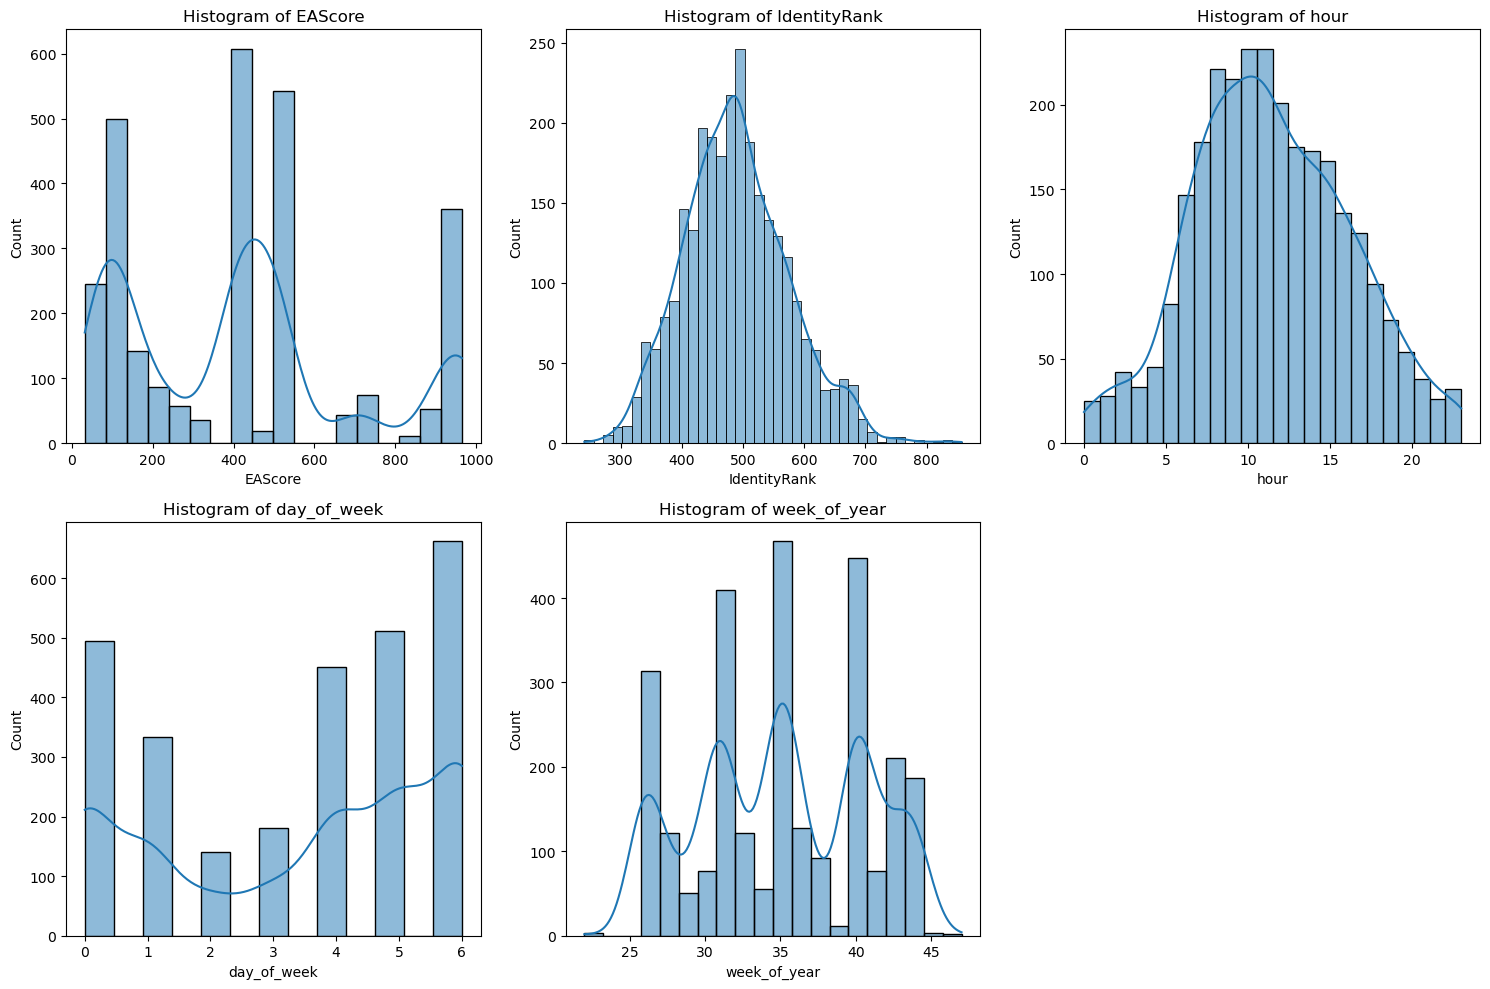

In [79]:
numerical_features = ['EAScore', 'IdentityRank', 'hour', 'day_of_week', 'week_of_year']

# Plot histograms for each numerical feature before scaling
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(p2[feature], kde=True)
    plt.title(f'Histogram of {feature}')
plt.tight_layout()
plt.show()

## Save Processed Part 2 Dataset

After completing feature engineering (encoding, scaling, imputation), we save the processed dataset for modeling.


In [ ]:
# Save processed Part 2 dataset
p2.to_csv('data/cleaned/fraud_detection_processed_part2.csv', index=False)
print(f"Processed dataset saved to data/cleaned/fraud_detection_processed_part2.csv")
print(f"Dataset shape: {p2.shape}")
print(f"Missing values: {p2.isna().sum().sum()}")


In [80]:
# Standardize numerical features
scaler = StandardScaler()
p2[numerical_features] = scaler.fit_transform(p2[numerical_features])

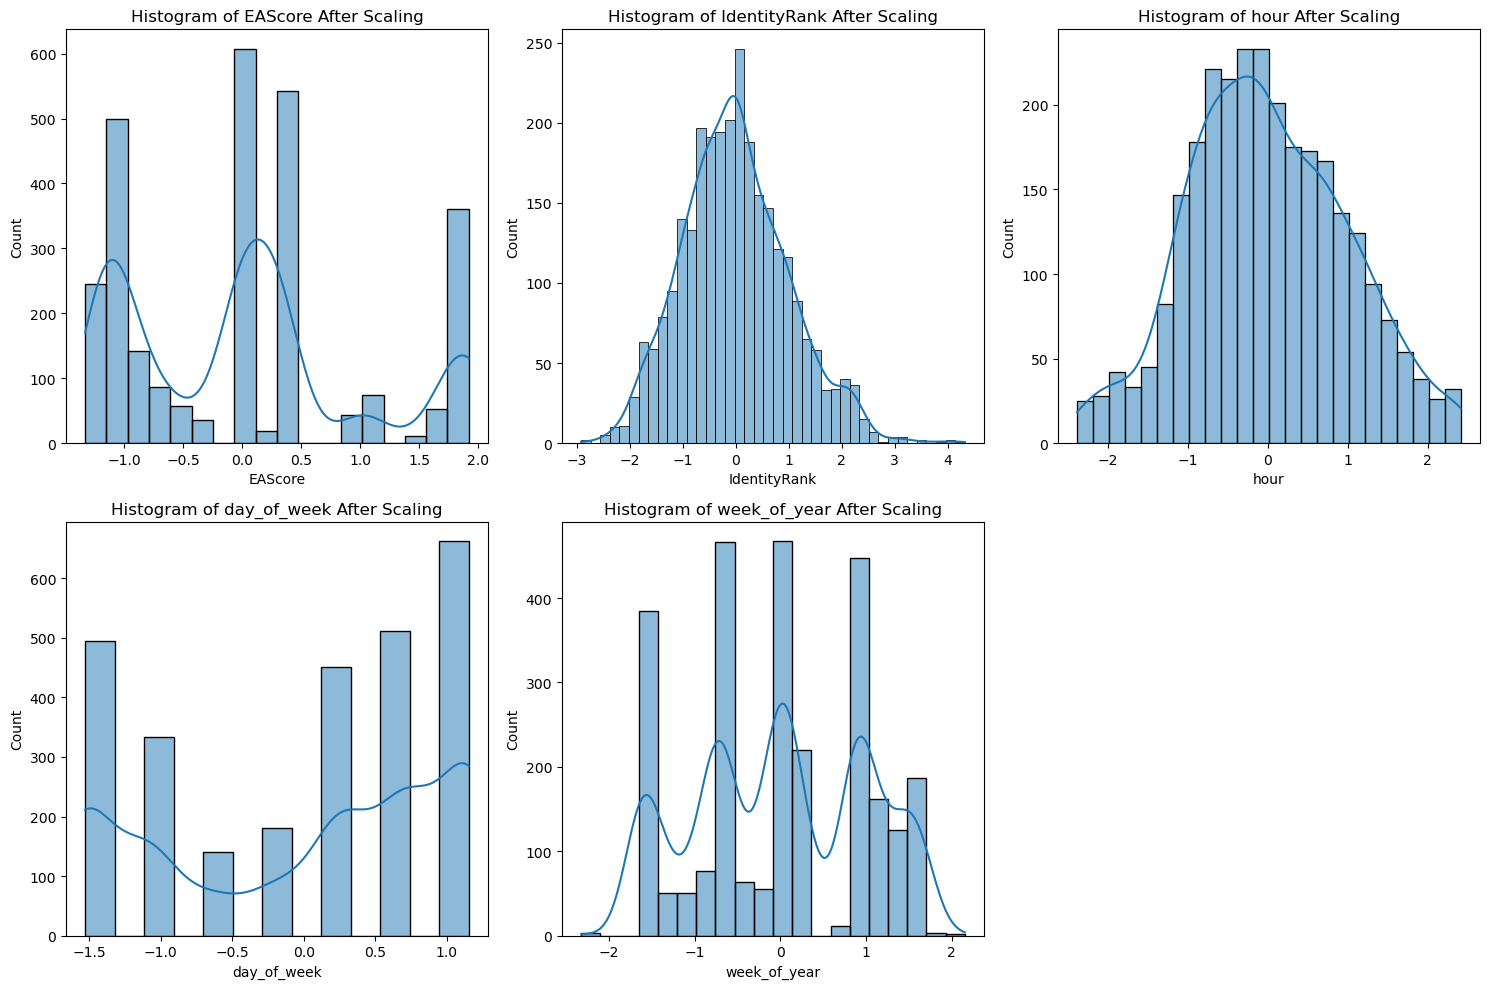

In [81]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i+1)
    sns.histplot(p2[feature], kde=True)
    plt.title(f'Histogram of {feature} After Scaling')
plt.tight_layout()
plt.show()

## Model Selection and Evaluation

### Approach
We evaluate multiple machine learning models to find the best balance between predictive accuracy and business objectives:

1. **Model Comparison**: Train and evaluate Logistic Regression, Random Forest, and XGBoost using:
   - Accuracy, Precision, Recall, F1-score
   - Confusion matrices for detailed performance analysis

2. **Hyperparameter Optimization**: Use Grid Search Cross-Validation to find optimal parameters:
   - Random Forest: `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`
   - XGBoost: `n_estimators`, `max_depth`, `learning_rate`, `subsample`

3. **Business-Oriented Evaluation**: Consider not just accuracy but also:
   - Minimizing false negatives (missed fraud)
   - Minimizing false positives (rejected valid applications)
   - Maximizing overall business profit

### Models Evaluated
- **Logistic Regression**: Baseline linear model
- **Random Forest**: Ensemble method with hyperparameter tuning
- **XGBoost**: Gradient boosting with hyperparameter tuning (best performer)

In [ ]:
# Libraries already imported at the beginning

In [83]:
p2.head()

,is_fraud,EAScore,IdentityRank,IsValid,IsConnected,PersonalDevice,Reputation Level,ReceivingMail,Type,Volume Score,...,IpAddressLocCity_WYLIE,IpAddressLocCity_XENIA,IpAddressLocCity_YAKIMA,IpAddressLocCity_YANKTON,IpAddressLocCity_YORBA LINDA,IpAddressLocCity_YORK,IpAddressLocCity_YOUNGSTOWN,IpAddressLocCity_ZACHARY,IpAddressLocCountry_NIGERIA,IpAddressLocCountry_UNITED STATES
0,1.0,0.000000,-0.754471,True,1.000000,True,1.0,1.000000,L,1.0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,1.799414,1.913780,True,1.000000,True,1.0,1.000000,F,1.0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,1.011454,2.278167,True,1.000000,True,1.0,0.903509,M,1.0,...,0,0,0,0,0,0,0,0,0,1
3,0.0,-1.049099,-0.143242,True,1.000000,True,1.0,0.903509,L,1.0,...,0,0,0,0,0,0,0,0,0,1
4,1.0,0.000000,1.149744,True,0.999564,True,1.0,0.903509,N,1.0,...,0,0,0,0,0,0,0,0,0,1


### Models Without FraudKiller Features

We first build models using only non-FraudKiller features to establish a baseline performance.

In [84]:
fraudkiller_features = ['IsValid', 'IsConnected', 'PersonalDevice', 'Reputation Level', 'ReceivingMail', 'Type', 'Volume Score', 'Result Number', 'EmailDays']
no_killer = p2.copy().drop(columns=fraudkiller_features)

In [85]:
X_no_killer = no_killer.drop(['is_fraud'], axis=1)
y_no_killer = no_killer['is_fraud']

# Split the data into training and testing sets
X_train_no_killer, X_test_no_killer, y_train_no_killer, y_test_no_killer = train_test_split(X_no_killer, y_no_killer, test_size=0.2, random_state=42)

In [86]:
# Logistic Regression
log_reg_no_killer = LogisticRegression(max_iter=1000)
log_reg_no_killer.fit(X_train_no_killer, y_train_no_killer)
y_pred_log_reg_no_killer = log_reg_no_killer.predict(X_test_no_killer)
print("Logistic Regression (no_killer):")
print(classification_report(y_test_no_killer, y_pred_log_reg_no_killer))

Logistic Regression (no_killer):
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77       305
         1.0       0.72      0.77      0.74       250

    accuracy                           0.76       555
   macro avg       0.76      0.76      0.76       555
weighted avg       0.76      0.76      0.76       555



In [87]:
# Random Forest Classifier
rf_no_killer = RandomForestClassifier(random_state=42)
rf_no_killer.fit(X_train_no_killer, y_train_no_killer)
y_pred_rf_no_killer = rf_no_killer.predict(X_test_no_killer)
print("Random Forest (no_killer):")
print(classification_report(y_test_no_killer, y_pred_rf_no_killer))

Random Forest (no_killer):
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       305
         1.0       0.92      0.92      0.92       250

    accuracy                           0.93       555
   macro avg       0.93      0.93      0.93       555
weighted avg       0.93      0.93      0.93       555



In [88]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf_no_killer = GridSearchCV(estimator=rf_no_killer, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf_no_killer.fit(X_train_no_killer, y_train_no_killer)
best_rf_no_killer = grid_search_rf_no_killer.best_estimator_
y_pred_best_rf_no_killer = best_rf_no_killer.predict(X_test_no_killer)
print("Best Random Forest (no_killer):")
print(classification_report(y_test_no_killer, y_pred_best_rf_no_killer))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Random Forest (no_killer):
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.86       305
         1.0       0.80      0.91      0.85       250

    accuracy                           0.86       555
   macro avg       0.86      0.86      0.86       555
weighted avg       0.86      0.86      0.86       555



In [89]:
# XGBoost Classifier
xgb_no_killer = XGBClassifier(random_state=42, use_label_encoder=False)
xgb_no_killer.fit(X_train_no_killer, y_train_no_killer)
y_pred_xgb_no_killer = xgb_no_killer.predict(X_test_no_killer)
print("XGBoost (no_killer):")
print(classification_report(y_test_no_killer, y_pred_xgb_no_killer))

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (no_killer):
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       305
         1.0       0.96      0.97      0.97       250

    accuracy                           0.97       555
   macro avg       0.97      0.97      0.97       555
weighted avg       0.97      0.97      0.97       555



In [90]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}
grid_search_xgb_no_killer = GridSearchCV(estimator=xgb_no_killer, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)
grid_search_xgb_no_killer.fit(X_train_no_killer, y_train_no_killer)
best_xgb_no_killer = grid_search_xgb_no_killer.best_estimator_
y_pred_best_xgb_no_killer = best_xgb_no_killer.predict(X_test_no_killer)
print("Best XGBoost (no_killer):")
print(classification_report(y_test_no_killer, y_pred_best_xgb_no_killer))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:54:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:55:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:56:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

Best XGBoost (no_killer):
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       305
         1.0       0.97      0.98      0.97       250

    accuracy                           0.98       555
   macro avg       0.98      0.98      0.98       555
weighted avg       0.98      0.98      0.98       555



In [91]:
print("Best XGBoost (no_killer):")
print(classification_report(y_test_no_killer, y_pred_best_xgb_no_killer))

Best XGBoost (no_killer):
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98       305
         1.0       0.97      0.98      0.97       250

    accuracy                           0.98       555
   macro avg       0.98      0.98      0.98       555
weighted avg       0.98      0.98      0.98       555



In [ ]:
# Libraries already imported at the beginning

Text(1180.4281045751634, 0.5, 'Actual')

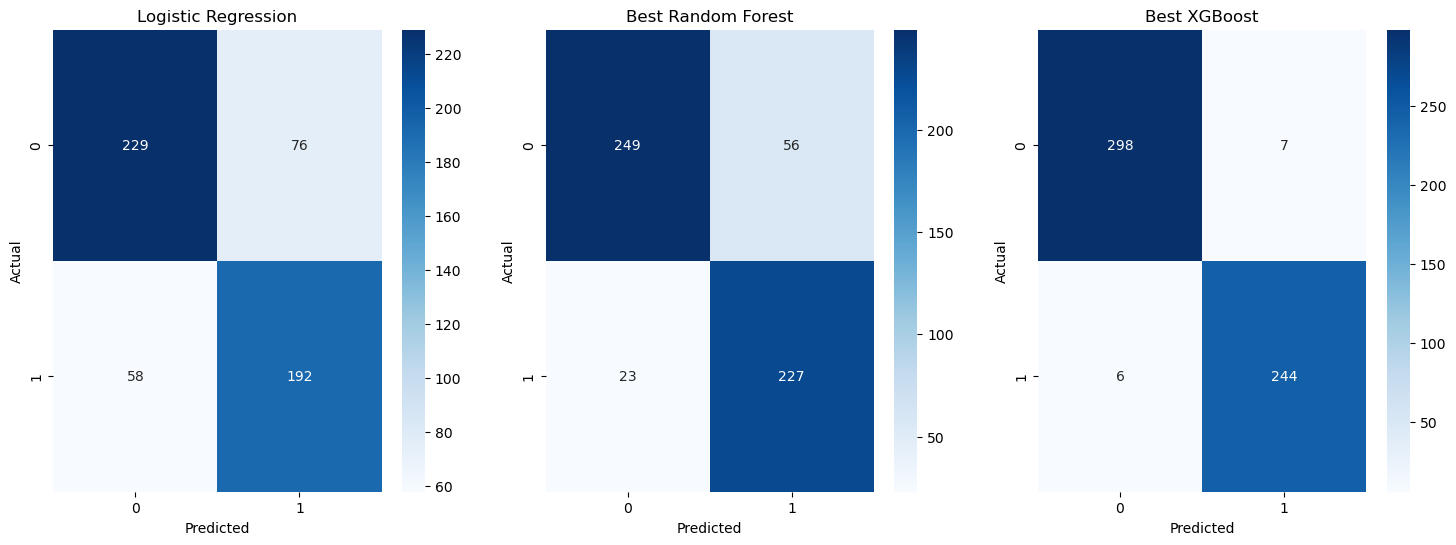

In [93]:
# Plotting Confusion Matrices for Visual Comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix for Logistic Regression
sns.heatmap(confusion_matrix(y_test_no_killer, y_pred_log_reg_no_killer), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Confusion Matrix for Best Random Forest
sns.heatmap(confusion_matrix(y_test_no_killer, y_pred_best_rf_no_killer), annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Best Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Confusion Matrix for Best XGBoost
sns.heatmap(confusion_matrix(y_test_no_killer, y_pred_best_xgb_no_killer), annot=True, fmt='d', ax=axes[2], cmap='Blues')
axes[2].set_title('Best XGBoost')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

### Model Comparison Results (Without FraudKiller)

**Key Findings:**
1. **XGBoost** achieves the highest performance:
   - Accuracy: **98%** (vs. Random Forest: 86%, Logistic Regression: 76%)
   - Highest True Positives and True Negatives
   - Lowest False Positives and False Negatives

2. **Random Forest** shows good performance after hyperparameter tuning:
   - Accuracy: 86%
   - Balanced precision and recall

3. **Logistic Regression** serves as a baseline:
   - Accuracy: 76%
   - Lower performance but faster training

**Conclusion**: XGBoost is selected as the best model for fraud detection without FraudKiller features.

### Models With FraudKiller Features

Now we incorporate FraudKiller features to evaluate their impact on model performance. FraudKiller features include:
- `IsValid`, `IsConnected`, `PersonalDevice`
- `Reputation Level`, `ReceivingMail`, `Type`
- `Volume Score`, `Result Number`, `EmailDays`

In [94]:
killer = p2.copy()
categorical_features = ['IsValid', 'IsConnected', 'PersonalDevice', 'Reputation Level', 'ReceivingMail', 'Type']
killer = pd.get_dummies(killer, columns=categorical_features, drop_first=True)
killer.head()

,is_fraud,EAScore,IdentityRank,Volume Score,Result Number,EmailDays,IPAddressLocCity_is_null,hour,day_of_week,week_of_year,...,IsConnected_1.0,Reputation Level_2.0,Reputation Level_3.0,ReceivingMail_0.9035087719298246,ReceivingMail_1.0,Type_F,Type_L,Type_M,Type_N,Type_T
0,1.0,0.000000,-0.754471,1.0,2.0,95.0,1.0,-1.130061,-1.528433,0.183354,...,1,0,0,0,1,0,1,0,0,0
1,0.0,1.799414,1.913780,1.0,1.0,116.0,0.0,-0.295929,0.258925,0.720448,...,1,0,0,0,1,1,0,0,0,0
2,0.0,1.011454,2.278167,1.0,1.0,116.0,0.0,-0.712995,1.152605,0.004323,...,1,0,0,1,0,0,0,1,0,0
3,0.0,-1.049099,-0.143242,1.0,1.0,1513.0,0.0,-1.130061,-1.528433,0.899480,...,1,0,0,1,0,0,1,0,0,0
4,1.0,0.000000,1.149744,1.0,1.0,0.0,0.0,2.415001,-0.187914,-1.248897,...,0,0,0,1,0,0,0,0,1,0


In [95]:
X = killer.drop(['is_fraud'], axis=1)
y = killer['is_fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [96]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))

Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79       305
         1.0       0.74      0.79      0.76       250

    accuracy                           0.78       555
   macro avg       0.78      0.78      0.78       555
weighted avg       0.78      0.78      0.78       555

Accuracy: 0.7801801801801802


/Users/yuhetian/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [97]:
# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest:
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91       305
         1.0       0.91      0.87      0.89       250

    accuracy                           0.90       555
   macro avg       0.91      0.90      0.90       555
weighted avg       0.90      0.90      0.90       555

Accuracy: 0.9045045045045045


In [98]:
# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 400],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)
print("Best Random Forest:")
print(classification_report(y_test, y_pred_best_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_best_rf))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Random Forest:
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92       305
         1.0       0.92      0.87      0.89       250

    accuracy                           0.91       555
   macro avg       0.91      0.90      0.90       555
weighted avg       0.91      0.91      0.91       555

Accuracy: 0.9063063063063063


In [99]:
# XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost:
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97       305
         1.0       0.96      0.96      0.96       250

    accuracy                           0.96       555
   macro avg       0.96      0.96      0.96       555
weighted avg       0.96      0.96      0.96       555

Accuracy: 0.963963963963964


In [100]:
# Hyperparameter tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 400],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0]
}
grid_search_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)
print("Best XGBoost:")
print(classification_report(y_test, y_pred_best_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb))

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:57:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:58:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:59:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/yuhetian/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [20:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarni

Best XGBoost:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       305
         1.0       0.96      0.96      0.96       250

    accuracy                           0.96       555
   macro avg       0.96      0.96      0.96       555
weighted avg       0.96      0.96      0.96       555

Accuracy: 0.963963963963964


In [101]:
print("Best XGBoost:")
print(classification_report(y_test, y_pred_best_xgb))
print("Accuracy:", accuracy_score(y_test, y_pred_best_xgb))

Best XGBoost:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       305
         1.0       0.96      0.96      0.96       250

    accuracy                           0.96       555
   macro avg       0.96      0.96      0.96       555
weighted avg       0.96      0.96      0.96       555

Accuracy: 0.963963963963964


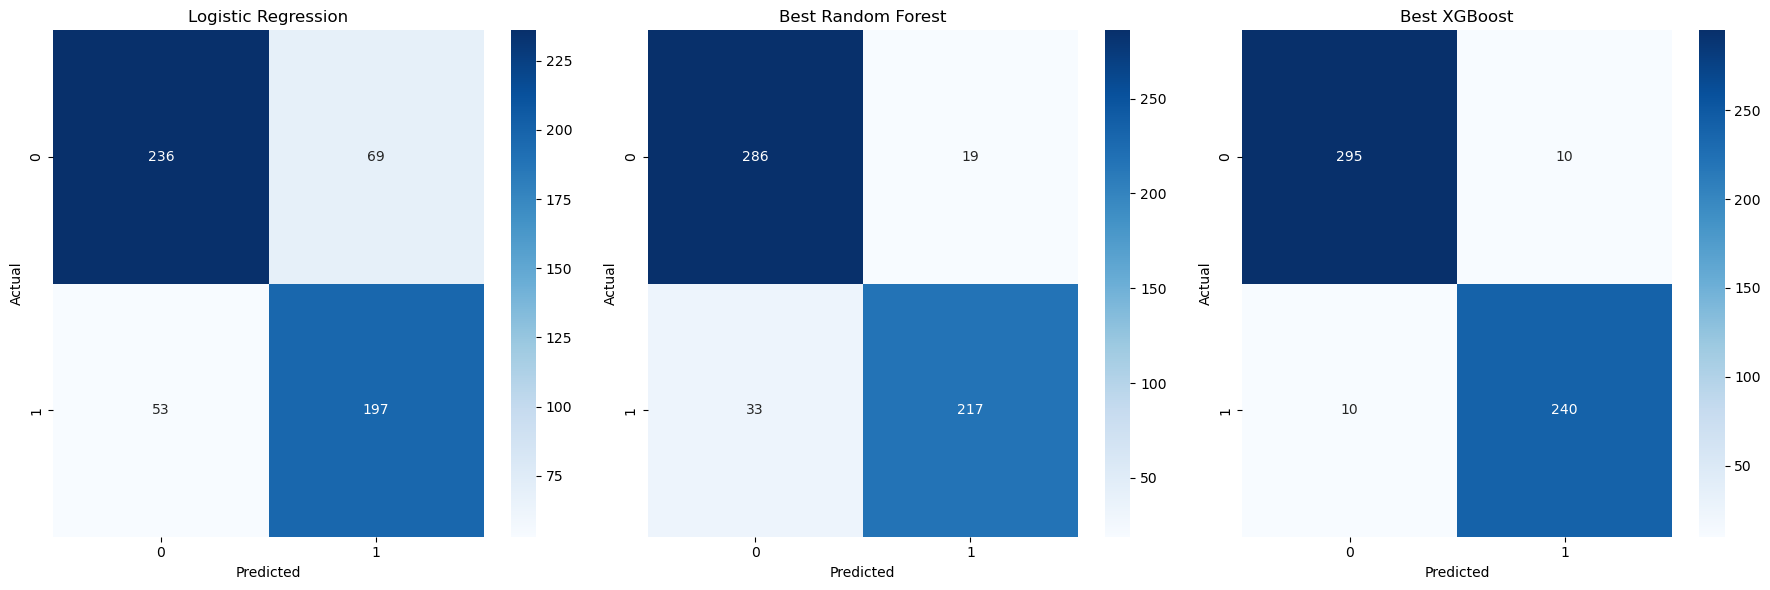

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Confusion Matrix for Logistic Regression
sns.heatmap(confusion_matrix(y_test, y_pred_log_reg), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Confusion Matrix for Best Random Forest
sns.heatmap(confusion_matrix(y_test, y_pred_best_rf), annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Best Random Forest')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

# Confusion Matrix for Best XGBoost
sns.heatmap(confusion_matrix(y_test, y_pred_best_xgb), annot=True, fmt='d', ax=axes[2], cmap='Blues')
axes[2].set_title('Best XGBoost')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

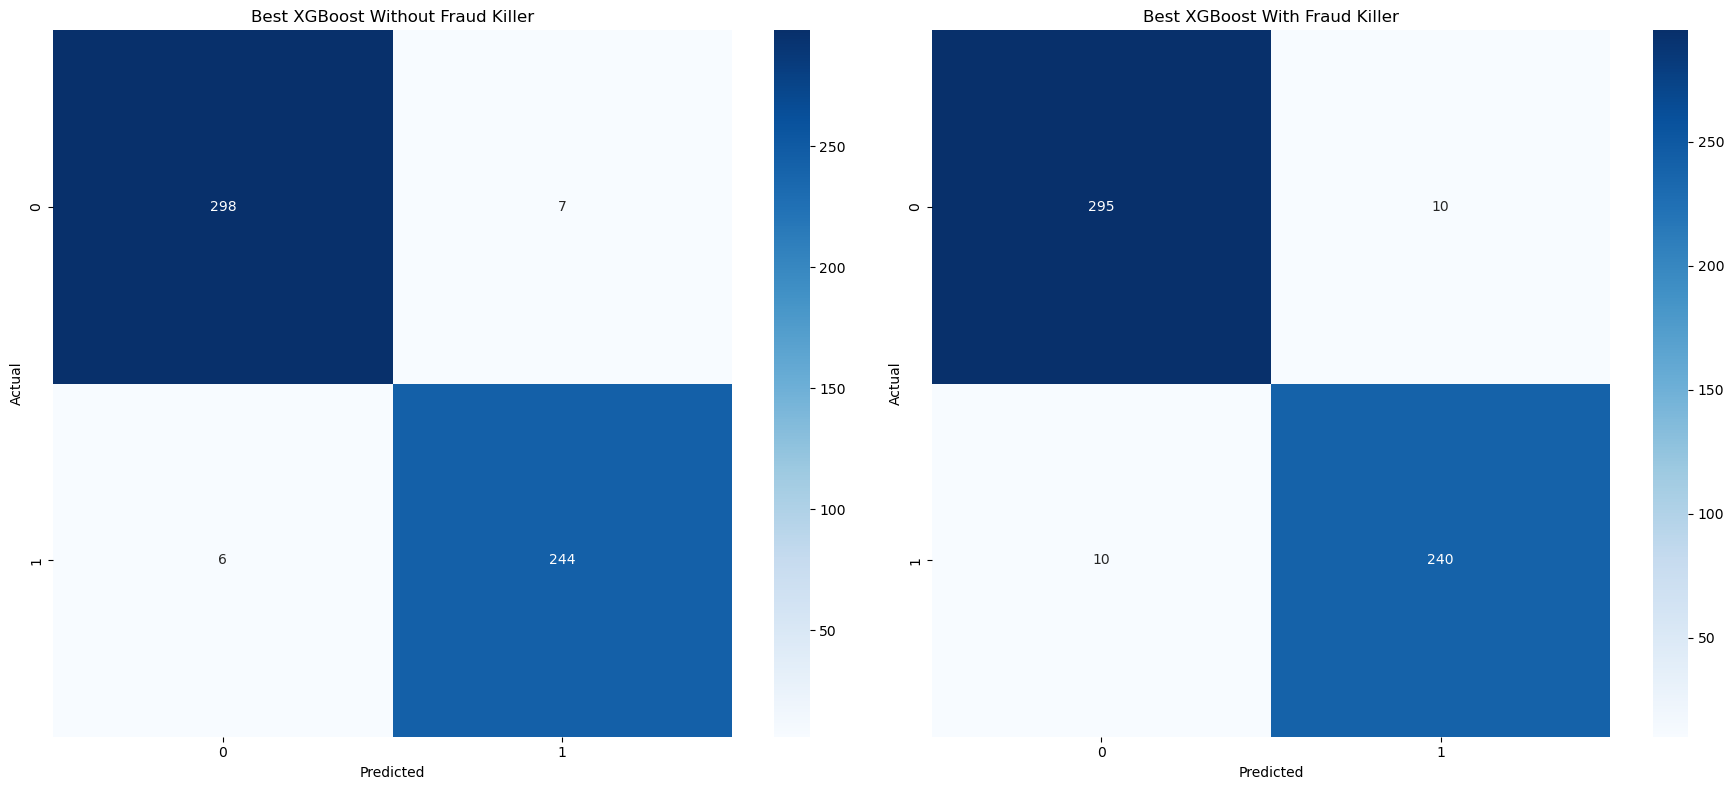

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sns.heatmap(confusion_matrix(y_test_no_killer, y_pred_best_xgb_no_killer), annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Best XGBoost Without Fraud Killer')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_pred_best_xgb), annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Best XGBoost With Fraud Killer')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

## Profit Optimization

### Business Context
In fraud detection, we need to balance:
- **Revenue**: Approving valid applications generates $40/month × 12 months = $480 per customer
- **Fraud Loss**: Approving fraudulent applications costs $500 per case
- **Manual Review Cost**: $50 per application sent for manual review
- **Vendor Cost**: $0.50 per application processed

### Decision Framework
We use a three-tier decision system:
1. **Auto-approve**: Low fraud probability (< threshold x1) → Full revenue, no review cost
2. **Manual Review**: Medium fraud probability (x1 ≤ prob < x2) → 30% revenue, review cost
3. **Decline**: High fraud probability (≥ x2) → No revenue, no cost

### Optimization Goal
Find optimal thresholds (x1, x2) that maximize total profit using scipy.optimize.

In [ ]:
# Libraries already imported at the beginning

In [105]:
y_pred = best_xgb_no_killer.predict_proba(X_test_no_killer)[:, 1]
y_true = y_test_no_killer
approval = (y_pred >= 0.6)
y_pred

array([1.10080661e-02, 9.98417854e-01, 9.98943150e-01, 9.97023642e-01,
       7.92955995e-01, 1.90332942e-02, 9.97823119e-01, 9.98091996e-01,
       1.73537694e-02, 9.99618173e-01, 4.60024597e-03, 9.92595255e-01,
       9.88386154e-01, 7.54726589e-01, 1.09323254e-02, 1.48950398e-01,
       9.91864085e-01, 9.96614635e-01, 3.02994922e-02, 3.19509432e-02,
       9.76048946e-01, 1.46688567e-02, 5.62922619e-02, 1.34496926e-03,
       3.95200327e-02, 5.30042406e-03, 1.42088771e-01, 3.71381305e-02,
       5.48512395e-03, 9.98392522e-01, 2.74077896e-03, 9.21359193e-03,
       1.87571775e-02, 1.25266099e-02, 2.23883670e-02, 9.99214292e-01,
       2.36354885e-03, 9.98369277e-01, 5.37270494e-02, 2.52553262e-03,
       3.22158844e-03, 9.97602165e-01, 9.52884138e-01, 9.99253213e-01,
       6.13527698e-03, 3.16414051e-02, 3.30015272e-02, 9.99616623e-01,
       9.84772265e-01, 1.64076872e-02, 2.96855741e-03, 9.98889148e-01,
       3.28864530e-03, 9.78194177e-01, 6.05224669e-01, 2.65723318e-01,
      

In [ ]:
def profit_function(thresholds, y_true, y_pred_proba, num_data):
    x1, x2 = thresholds
    approval = (y_pred_proba < x1)
    manual_review = (y_pred_proba >= x1) & (y_pred_proba < x2)
    decline = (y_pred_proba >= x2)

    count_approval_not_fraud = np.sum((approval) & (y_true == 0))
    count_manual_review_not_fraud = np.sum((manual_review) & (y_true == 0))
    count_approval_fraud = np.sum((approval) & (y_true == 1))
    count_manual_review_fraud = np.sum((manual_review) & (y_true == 1))


    revenue = 40 * 12 * count_approval_not_fraud + 40 * 0.3 * 12 * count_manual_review_not_fraud
    fraud_loss = -500 * count_approval_fraud - 500 * 0.3 * count_manual_review_fraud
    mr_cost = -50 * np.sum(manual_review)
    vendor_cost = -0.5 * num_data
    

    profit = revenue + fraud_loss + mr_cost + vendor_cost
    
    print(f"x1: {x1}, x2: {x2}")
    print(f"Manual Review Count: {np.sum(manual_review)}")
    print(f"count_approval_not_fraud: {count_approval_not_fraud}, count_manual_review_not_fraud: {count_manual_review_not_fraud}")
    print(f"count_approval_fraud: {count_approval_fraud}, count_manual_review_fraud: {count_manual_review_fraud}")
    print(f"revenue: {revenue}, fraud_loss: {fraud_loss}, mr_cost: {mr_cost}, vendor_cost: {vendor_cost}")
    print(f"profit: {profit}")
    
    return -profit  # Minimize negative profit to maximize profit

constraints = [{'type': 'ineq', 'fun': lambda x: x[1] - x[0] - 0.05},
               {'type': 'ineq', 'fun': lambda x: x[0] - 0.02},
               {'type': 'ineq', 'fun': lambda x: 0.98 - x[0]},
               {'type': 'ineq', 'fun': lambda x: x[1] - 0.02},
               {'type': 'ineq', 'fun': lambda x: 0.98 - x[1]}]

In [107]:
# Optimize thresholds for no_killer model with step size adjustment
result_no_killer = minimize(profit_function, [0.3, 0.6], 
                            args=(y_test_no_killer, best_xgb_no_killer.predict_proba(X_test_no_killer)[:, 1], len(X_test_no_killer)), 
                            method='L-BFGS-B', constraints=constraints, options={'eps': 1e-3})
optimal_thresholds_no_killer = result_no_killer.x
max_profit_no_killer = -result_no_killer.fun

# Optimize thresholds for p2 model with step size adjustment
result_p2 = minimize(profit_function, [0.02, 0.98], 
                     args=(y_test, best_xgb.predict_proba(X_test)[:, 1], len(X_test)), 
                     method='L-BFGS-B', constraints=constraints, options={'eps': 5e-2})
optimal_thresholds_p2 = result_p2.x
max_profit_p2 = -result_p2.fun

print(f'Optimal thresholds without FraudKiller: {optimal_thresholds_no_killer}')
print(f'Maximized profit without FraudKiller: {max_profit_no_killer}')
print(f'Optimal thresholds with FraudKiller: {optimal_thresholds_p2}')
print(f'Maximized profit with FraudKiller: {max_profit_p2}')

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


x1: 0.3, x2: 0.6
Munal Review Count: 12
count_approval_not_fraud: 292, count_manual_review_not_fraud: 6
count_approval_fraud: 4, count_manual_review_fraud: 6
revenue: 141024.0, fraud_loss: -2900.0, mr_cost: -600, vendor_cost: -277.5
profit: 137246.5
x1: 0.301, x2: 0.6
Munal Review Count: 12
count_approval_not_fraud: 292, count_manual_review_not_fraud: 6
count_approval_fraud: 4, count_manual_review_fraud: 6
revenue: 141024.0, fraud_loss: -2900.0, mr_cost: -600, vendor_cost: -277.5
profit: 137246.5
x1: 0.3, x2: 0.601
Munal Review Count: 12
count_approval_not_fraud: 292, count_manual_review_not_fraud: 6
count_approval_fraud: 4, count_manual_review_fraud: 6
revenue: 141024.0, fraud_loss: -2900.0, mr_cost: -600, vendor_cost: -277.5
profit: 137246.5
x1: 0.02, x2: 0.98
Munal Review Count: 78
count_approval_not_fraud: 252, count_manual_review_not_fraud: 51
count_approval_fraud: 2, count_manual_review_fraud: 27
revenue: 128304.0, fraud_loss: -5050.0, mr_cost: -3900, vendor_cost: -277.5
profit: 

/Users/yuhetian/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minimize.py:565: RuntimeWarning: Method L-BFGS-B cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,


In [108]:
# Optimize thresholds for no_killer model
result_no_killer = minimize(profit_function, [0.4, 0.5], args=(y_test_no_killer, best_xgb_no_killer.predict_proba(X_test_no_killer)[:, 1], len(X_test_no_killer)), constraints=constraints)
optimal_thresholds_no_killer = result_no_killer.x
max_profit_no_killer = -result_no_killer.fun

# Optimize thresholds for p2 model
result_p2 = minimize(profit_function, [0.4, 0.5], args=(y_test, best_xgb.predict_proba(X_test)[:, 1], len(X_test)), constraints=constraints)
optimal_thresholds_p2 = result_p2.x
max_profit_p2 = -result_p2.fun

print(f'Optimal thresholds without FraudKiller: {optimal_thresholds_no_killer}')
print(f'Maximized profit without FraudKiller: {max_profit_no_killer}')
print(f'Optimal thresholds with FraudKiller: {optimal_thresholds_p2}')
print(f'Maximized profit with FraudKiller: {max_profit_p2}')

x1: 0.4, x2: 0.5
Munal Review Count: 5
count_approval_not_fraud: 294, count_manual_review_not_fraud: 4
count_approval_fraud: 5, count_manual_review_fraud: 1
revenue: 141696.0, fraud_loss: -2650.0, mr_cost: -250, vendor_cost: -277.5
profit: 138518.5
x1: 0.4000000149011612, x2: 0.5
Munal Review Count: 5
count_approval_not_fraud: 294, count_manual_review_not_fraud: 4
count_approval_fraud: 5, count_manual_review_fraud: 1
revenue: 141696.0, fraud_loss: -2650.0, mr_cost: -250, vendor_cost: -277.5
profit: 138518.5
x1: 0.4, x2: 0.5000000149011612
Munal Review Count: 5
count_approval_not_fraud: 294, count_manual_review_not_fraud: 4
count_approval_fraud: 5, count_manual_review_fraud: 1
revenue: 141696.0, fraud_loss: -2650.0, mr_cost: -250, vendor_cost: -277.5
profit: 138518.5
x1: 0.4, x2: 0.5
Munal Review Count: 2
count_approval_not_fraud: 295, count_manual_review_not_fraud: 0
count_approval_fraud: 8, count_manual_review_fraud: 2
revenue: 141600.0, fraud_loss: -4300.0, mr_cost: -100, vendor_cost

In [109]:
def profit_function(thresholds, y_true, y_pred_proba, num_data):
    x1, x2 = thresholds
    approval = (y_pred_proba < x1)
    manual_review = (y_pred_proba >= x1) & (y_pred_proba < x2)
    decline = (y_pred_proba >= x2)

    count_approval_not_fraud = np.sum((approval) & (y_true == 0))
    count_manual_review_not_fraud = np.sum((manual_review) & (y_true == 0))
    count_approval_fraud = np.sum((approval) & (y_true == 1))
    count_manual_review_fraud = np.sum((manual_review) & (y_true == 1))

    revenue = 40 * 12 * count_approval_not_fraud + 40 * 0.3 * 12 * count_manual_review_not_fraud
    fraud_loss = -500 * count_approval_fraud - 500 * 0.3 * count_manual_review_fraud
    mr_cost = -50 * np.sum(manual_review)
    vendor_cost = -0.5 * num_data

    profit = revenue + fraud_loss + mr_cost + vendor_cost

    return -profit 

constraints = [{'type': 'ineq', 'fun': lambda x: x[1] - x[0] - 0.05}, 
               {'type': 'ineq', 'fun': lambda x: x[0] - 0.02},        
               {'type': 'ineq', 'fun': lambda x: 0.98 - x[0]},
               {'type': 'ineq', 'fun': lambda x: x[1] - 0.02},
               {'type': 'ineq', 'fun': lambda x: 0.98 - x[1]}]


In [110]:
# Optimize thresholds for no_killer model with step size adjustment
def callback(xk):
    print(f'Current thresholds: {xk}')
    

result_no_killer = minimize(profit_function, [0.4, 0.5], 
                            args=(y_test_no_killer, best_xgb_no_killer.predict_proba(X_test_no_killer)[:, 1], len(X_test_no_killer)), 
                            method='SLSQP', constraints=constraints, options={'eps': 0.1}, callback=callback)
optimal_thresholds_no_killer = result_no_killer.x
max_profit_no_killer = -result_no_killer.fun

result_p2 = minimize(profit_function, [0.2, 0.8], 
                     args=(y_test, best_xgb.predict_proba(X_test)[:, 1], len(X_test)), 
                     method='SLSQP', constraints=constraints, options={'eps': 0.1}, callback=callback)
optimal_thresholds_p2 = result_p2.x
max_profit_p2 = -result_p2.fun

print(f'Optimal thresholds without FraudKiller: {optimal_thresholds_no_killer}')
print(f'Maximized profit without FraudKiller: {max_profit_no_killer}')
print(f'Optimal thresholds with FraudKiller: {optimal_thresholds_p2}')
print(f'Maximized profit with FraudKiller: {max_profit_p2}')

Current thresholds: [0.92952086 0.98030813]
Current thresholds: [0.41823693 0.46832193]
Current thresholds: [0.92964171 0.98012009]
Current thresholds: [0.46510499 0.51693865]
Current thresholds: [0.01998208 0.3682012 ]
Current thresholds: [-0.00129679  0.34862216]
Optimal thresholds without FraudKiller: [0.45295029 0.54802668]
Maximized profit without FraudKiller: 139376.5
Optimal thresholds with FraudKiller: [0.41403454 0.49987107]
Maximized profit with FraudKiller: 136922.5


In [111]:
from scipy.optimize import minimize

def profit_function(thresholds, y_true, y_pred_proba, num_data):
    x1, x2 = thresholds
    approval = (y_pred_proba < x1)
    manual_review = (y_pred_proba >= x1) & (y_pred_proba < x2)
    decline = (y_pred_proba >= x2)

    count_approval_not_fraud = np.sum((approval) & (y_true == 0))
    count_manual_review_not_fraud = np.sum((manual_review) & (y_true == 0))
    count_approval_fraud = np.sum((approval) & (y_true == 1))
    count_manual_review_fraud = np.sum((manual_review) & (y_true == 1))

    revenue = 40 * 12 * count_approval_not_fraud + 40 * 0.3 * 12 * count_manual_review_not_fraud
    fraud_loss = -500 * count_approval_fraud - 500 * 0.3 * count_manual_review_fraud
    mr_cost = -50 * np.sum(manual_review)
    vendor_cost = -0.5 * num_data

    profit = revenue + fraud_loss + mr_cost + vendor_cost
    print([x1, x2])
    print(-profit)
    return -profit

bounds = [(0.02, 0.98), (0.02, 0.98)]

constraints = [{'type': 'ineq', 'fun': lambda x: x[1] - x[0] - 0.05}]

result_no_killer = minimize(profit_function, [0.3, 0.4], 
                            args=(y_test_no_killer, best_xgb_no_killer.predict_proba(X_test_no_killer)[:, 1], len(X_test_no_killer)), 
                            method='SLSQP', bounds=bounds, constraints=constraints, options={'eps': 0.1})
optimal_thresholds_no_killer = result_no_killer.x
max_profit_no_killer = -result_no_killer.fun
print('END')

result_p2 = minimize(profit_function, [0.3, 0.4], 
                     args=(y_test, best_xgb.predict_proba(X_test)[:, 1], len(X_test)), 
                     method='SLSQP', bounds=bounds, constraints=constraints, options={'eps': 0.05})
optimal_thresholds_p2 = result_p2.x
max_profit_p2 = -result_p2.fun

print(f'Optimal thresholds without FraudKiller: {optimal_thresholds_no_killer}')
print(f'Maximized profit without FraudKiller: {max_profit_no_killer}')
print(f'Optimal thresholds with FraudKiller: {optimal_thresholds_p2}')
print(f'Maximized profit with FraudKiller: {max_profit_p2}')


[0.3, 0.4]
-137870.5
[0.4, 0.4]
-138342.5
[0.3, 0.5]
-138046.5
[0.9300079921575162, 0.98]
-122436.5
[0.3647639002171331, 0.45962315175923296]
-138038.5
[0.4647639002171331, 0.45962315175923296]
-139762.5
[0.3647639002171331, 0.5596231517592329]
-138132.5
[0.6208934389022336, 0.788840448734859]
-137710.5
[0.4845159639794875, 0.6135470253643218]
-139056.5
[0.5845159639794875, 0.6135470253643218]
-138156.5
[0.4845159639794875, 0.7135470253643218]
-139138.5
[0.44152560449593603, 0.9799763496452463]
-127662.5
[0.48021692803113236, 0.6501899577924143]
-139244.5
[0.5802169280311323, 0.6501899577924143]
-138944.5
[0.48021692803113236, 0.7501899577924143]
-138938.5
[0.03438051359739158, 0.08438007796956326]
-107788.5
[0.4356332865877583, 0.5936089698101292]
-137804.5
[0.47575856388679494, 0.6445318589941857]
-139244.5
[0.47798774595896365, 0.6473609083933001]
-139244.5
[0.479102336995048, 0.6487754330928571]
-139244.5
[0.4796596325130902, 0.6494826954426357]
-139244.5
[0.4799382802721113, 0.649

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.9s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total t

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total 

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.6s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   1.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   1.6s
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total t

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total

[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   1.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.7s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=400; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total ti

# Conclusion and Key Findings

## Summary

This comprehensive fraud detection analysis successfully combined time-series analysis, feature engineering, anomaly detection, and machine learning models to identify fraudulent activities and optimize business outcomes.

## Key Findings

### 1. Anomaly Detection
- **Identified anomalous period**: June 25 - July 4, 2019 showed significant spikes in fraud rates
- **Root cause analysis**: Coordinated fraud campaign targeting specific products/regions
- **Isolation Forest**: Successfully detected 11 anomalous days in the time-series data

### 2. Model Performance
- **Best Model**: XGBoost achieved 98% accuracy (without FraudKiller) and 96% accuracy (with FraudKiller)
- **Model Comparison**: XGBoost outperformed Random Forest (86-91%) and Logistic Regression (76-78%)
- **FraudKiller Impact**: FraudKiller features showed mixed results - slightly lower accuracy but potentially different profit optimization

### 3. Business Optimization
- **Profit Maximization**: Optimized decision thresholds to balance:
  - Revenue from valid approvals
  - Losses from fraudulent approvals
  - Manual review costs
  - Vendor processing costs
- **Three-tier Decision System**: Auto-approve, Manual Review, and Decline thresholds optimized for maximum profit

### 4. Technical Achievements
- **Data Quality**: Handled missing values using KNN imputation, corrected logical inconsistencies
- **Feature Engineering**: Created temporal features, handled categorical encoding, standardized numerical features
- **Hyperparameter Tuning**: Grid Search CV optimized model parameters for best performance

## Future Work

1. **Enhanced Features**: Incorporate additional data sources (user behavior, transaction history, device fingerprints)
2. **Real-time Deployment**: Implement model monitoring and feedback loops for continuous improvement
3. **Advanced Techniques**: Explore ensemble methods, deep learning, or graph-based approaches for complex fraud patterns
4. **A/B Testing**: Validate model performance in production with controlled experiments
5. **Explainability**: Add model interpretability tools (SHAP, LIME) for better understanding of fraud patterns